In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [174]:
import sys
sys.path.insert(0, '../modules/')
import model
import utils
import rivernets

In [225]:
# Parameters of the dynamics
NDyn = 50

Nsteps = 5000
dt = 1e-2
cvec = np.ones(NDyn)*0.5
evec = np.ones(NDyn)*1

Time = np.arange(0, Nsteps*dt, dt)

rho_0 = np.ones(NDyn)*0.01

f_dyn = 0.5
xi_dyn = 3.5

In [226]:
net_RI = nx.cycle_graph(NDyn)

p_SW = 0.3
net_SW = nx.connected_watts_strogatz_graph(NDyn, 2, p_SW)

net_BA = nx.barabasi_albert_graph(NDyn, 1)

In [227]:
kernel_RI = model.find_effective_kernel(f_dyn, xi_dyn, net_RI)
kernel_SW = model.find_effective_kernel(f_dyn, xi_dyn, net_SW)
kernel_BA = model.find_effective_kernel(f_dyn, xi_dyn, net_BA)

/mnt/attached_volume/data_gnico/HanskiMicroModel/notebooks/../modules/model.py:115: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Laplacian = Laplacian.astype(np.complex128)
/mnt/attached_volume/data_gnico/HanskiMicroModel/notebooks/../modules/model.py:115: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  Laplacian = Laplacian.astype(np.complex128)


In [228]:
print(np.mean(evec/cvec), model.find_metapopulation_capacity(kernel_RI, net_RI, f_dyn, xi_dyn, undirected = True))
print(np.mean(evec/cvec), model.find_metapopulation_capacity(kernel_SW, net_SW, f_dyn, xi_dyn, undirected = True))
print(np.mean(evec/cvec), model.find_metapopulation_capacity(kernel_BA, net_BA, f_dyn, xi_dyn, undirected = True))

/mnt/attached_volume/data_gnico/HanskiMicroModel/notebooks/../modules/model.py:316: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  


2.0 2.333333333333335
2.0 2.6060285114836295
2.0 2.8434437416172917


/mnt/attached_volume/data_gnico/HanskiMicroModel/notebooks/../modules/model.py:316: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  


In [229]:
rho_RI = model.simulate(NDyn, Nsteps, dt, kernel_RI, cvec, evec, rho0 = rho_0)
rho_SW = model.simulate(NDyn, Nsteps, dt, kernel_SW, cvec, evec, rho0 = rho_0)
rho_BA = model.simulate(NDyn, Nsteps, dt, kernel_BA, cvec, evec, rho0 = rho_0)

In [230]:
lam = 1
x_RI = model.find_explorers_dyn(rho_RI, kernel_RI, cvec, lam)
x_SW = model.find_explorers_dyn(rho_SW, kernel_SW, cvec, lam)
x_BA = model.find_explorers_dyn(rho_BA, kernel_BA, cvec, lam)

In [175]:
path = '../data/RiverNet/SouthAmerica/'

f_dyn_riv = 1.8
xi_riv = 2 

##### Prepare the DEM #####
dem, grid = rivernets.get_DEM(path + "SouthAmerica.tif")
dem = grid.fill_pits(dem)
dem = grid.fill_depressions(dem)
dem = grid.resolve_flats(dem)

##### Compute the adjacency matrix #####
to_nn = np.array([[-1, 0], [0, 1], [1, 0], [0, -1],
                  [-1, 1], [1, 1], [1, -1], [-1, -1]])

slopes = rivernets.get_slopes(dem, to_nn = to_nn)

xmin, xmax = np.min(slopes[slopes != np.inf]), np.max(slopes[slopes != np.inf])

ymin = 1e-9
ymax = 1
beta = 0.0023

Dmatrix = rivernets.build_adjacency_elevation_exponential(dem, slopes,
                                                          xmin, xmax,
                                                          ymin, ymax,
                                                          beta, to_nn = to_nn)


##### Compute Laplacian and spectral decomposition #####
Laplacian = utils.find_laplacian_nb(Dmatrix)
Laplacian = Laplacian.astype(np.complex128)
L_eigvals, V, V_inv = utils.diagonalize_matrix(Laplacian.T)

NDyn_riv = Dmatrix.shape[0]

In [182]:
NDyn_riv = Dmatrix.shape[0]
Nsteps_riv = 50000
dt_riv = 1e-2
cvec_riv = np.ones(NDyn_riv)*1
evec_riv = np.ones(NDyn_riv)*1

Time_riv = np.arange(0, Nsteps_riv*dt_riv, dt_riv)

rho_0_riv = np.zeros(NDyn_riv)
rho_0_riv[0] = 1

Kriv = model.find_effective_kernel_nb(f_dyn_riv, xi_riv, Dmatrix, 
                                      Laplacian = Laplacian,
                                      L_eigvals = L_eigvals,
                                      V = V, V_inv = V_inv,
                                      undirected = False)

rho_riv = model.simulate(NDyn_riv, Nsteps_riv, dt_riv, Kriv, cvec_riv, evec_riv, rho0 = rho_0_riv)

In [188]:
x_riv_ss = model.find_explorers(rho_riv[-1], Kriv, cvec_riv, lam).reshape(*dem.shape)
rho_riv_ss = rho_riv[-1].reshape(*dem.shape)

In [207]:
colors_fig2 = ['#4d5257', "#6798c0", "#F2BC3D"]

colors_fig2_shaded = ['#7d7f82', "#6a8dba", "#e8c779"]
cmaps_fig2 = [utils.white_to_color_map(i) for i in colors_fig2]

color_fill = '#dadada'
color_edge = '#616161'

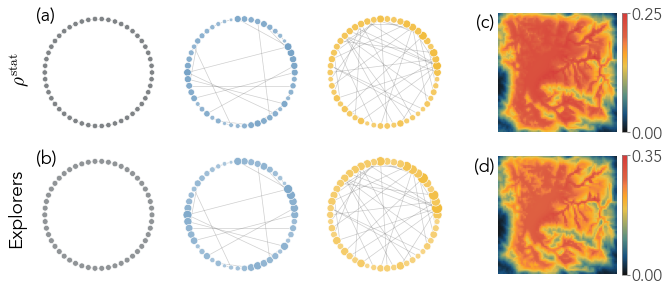

In [320]:
fig, ax_all = plt.subplots(nrows = 2, ncols = 4, figsize = (10, 5))

stat_population = [rho_RI[-1], rho_SW[-1], rho_BA[-1]]
stat_explorers = [x_RI[-1], x_SW[-1], x_BA[-1]]
vmax_rho = np.max(stat_population)
vmax_x = np.max(stat_explorers)
pos = [nx.circular_layout(net_RI), nx.circular_layout(net_SW), nx.circular_layout(net_BA)]

dict_list = ['stat_RI', 'stat_SW', 'stat_SF']

axs = [ax_all[0,0], ax_all[0,1], ax_all[0,2]]

for i, net in enumerate([net_RI, net_SW, net_BA]):

    nx.draw_networkx_nodes(net, pos = pos[i], node_size=stat_population[i]*200,
                           node_color=stat_population[i], cmap = utils.truncate_colormap(cmaps_fig2[i], 0.3, 1), alpha = 1,
                           linewidths=0.6, edgecolors='w', ax=axs[i], vmin = -0.2, vmax = vmax_rho)
                           
    nx.draw_networkx_edges(net, pos = pos[i], width=0.7, alpha=0.3, edge_color=color_edge, ax=axs[i])

    axs[i].axis('off')

axs = [ax_all[1,0], ax_all[1,1], ax_all[1,2]]

for i, net in enumerate([net_RI, net_SW, net_BA]):

    nx.draw_networkx_nodes(net, pos = pos[i], node_size=stat_explorers[i]*200,
                           node_color=stat_explorers[i], cmap = utils.truncate_colormap(cmaps_fig2[i], 0.3, 1), alpha = 1,
                           linewidths=0.6, edgecolors='w', ax=axs[i], vmin = -0.2, vmax = vmax_x)
                           
    nx.draw_networkx_edges(net, pos = pos[i], width=0.7, alpha=0.3, edge_color=color_edge, ax=axs[i])

    axs[i].axis('off')


plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax_all[0,0].text(-1.7, -0.15, r"$\rho^\mathrm{stat}$", fontsize = 19, rotation = 90)
ax_all[1,0].text(-1.7, -0.52, "Explorers", fontsize = 19, rotation = 90)

im_rho = ax_all[0,-1].imshow(rho_riv_ss, cmap = rivernets.cmap_statpop, vmin = 0, vmax = 0.25)
im_exp = ax_all[1,-1].imshow(x_riv_ss, cmap = rivernets.cmap_statpop, vmin = 0, vmax = 0.35)
ax_all[1,-1].axis('off')
ax_all[0,-1].axis('off')

cbar_exp = plt.colorbar(im_exp, ax = ax_all[1,-1], fraction = 0.046, pad = 0.04)
cbar_rho = plt.colorbar(im_rho, ax = ax_all[0,-1], fraction = 0.046, pad = 0.04)

cbar_rho.ax.set_yticks([0, 0.25])
cbar_exp.ax.set_yticks([0, 0.35])

for i in range(2):
    ax_all[i,3].set_position(ax_all[i,3].get_position().bounds + np.array([0.05, 0.0, 0.0, 0.0]))

cbar_exp.ax.set_position(cbar_exp.ax.get_position().bounds + np.array([0.05, 0.0, 0.0, 0.0]))
cbar_rho.ax.set_position(cbar_rho.ax.get_position().bounds + np.array([0.05, 0.0, 0.0, 0.0]))

ax_all[0,0].annotate('(a)', xy = (0.02, 0.9), xycoords = 'axes fraction', fontsize = 18)
ax_all[1,0].annotate('(b)', xy = (0.02, 0.9), xycoords = 'axes fraction', fontsize = 18)

ax_all[0, -1].annotate('(c)', xy = (-0.18, 0.88), xycoords = 'axes fraction', fontsize = 18)
ax_all[1, -1].annotate('(d)', xy = (-0.2, 0.865), xycoords = 'axes fraction', fontsize = 18)

plt.show()